# Model Building

In [ ]:
from platform import python_version
print(python_version())

In [ ]:
#Import the required Libraries
import numpy as np
import pandas as pd
from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [ ]:
raw_data = pd.read_csv("Trady Flow - Best Options Trade Ideas.csv")
pd.options.display.max_columns = None
raw_data.head()

In [ ]:
raw_data['Date'] = pd.to_datetime(raw_data['Time']).dt.date

In [ ]:
raw_data.head()

In [ ]:
raw_data.shape

In [ ]:
raw_data.groupby('Sym').size()

#### Renaming columns

In [ ]:
raw_data.rename(columns={raw_data.columns[1]: 'Symbols', raw_data.columns[2]: 'Option_type', raw_data.columns[3]: 'Expiry', raw_data.columns[4]: 'Strike_price', raw_data.columns[5]: 'Spot_price', raw_data.columns[8]: 'Volume', raw_data.columns[9]: 'Premium'},inplace=True)
raw_data.head()

#### Handling Datatypes

In [ ]:
raw_data['Expiry'] = pd.to_datetime(raw_data['Expiry']).dt.date
raw_data['Date'] = pd.to_datetime(raw_data['Date']).dt.date
raw_data.head()

In [ ]:
raw_data.dtypes

In [ ]:
repl_dict = {'[kK]': '*1e3', '[mM]': '*1e6', '[bB]': '*1e9', }
raw_data['Volume'] = raw_data['Volume'].replace(repl_dict, regex=True).map(pd.eval)
raw_data['Premium'] = raw_data['Premium'].replace(repl_dict, regex=True).map(pd.eval)

In [ ]:
raw_data.dtypes

In [ ]:
raw_data.describe()

#### Dropping insignificant columns from the data

In [ ]:
raw_data = raw_data.drop(['Time','OI','ITM'], 1)
raw_data.head()

In [ ]:
raw_data.describe()

In [ ]:
raw_data.shape

#### Filter the dataset only for "Call"

In [ ]:
df_call = raw_data.loc[(raw_data['Option_type'] == 'Call')]
df_call.head()

In [ ]:
# Replacing 'Call' value with 'c' for Implied Volatility calculation
df_call['Option_type'] = df_call['Option_type'].replace('Call','c')

In [ ]:
df_call.head()

In [ ]:
df_call.dtypes

In [ ]:
df_call.isnull().sum()

#### Calculating 'Time_to_Expiry' col
Time_to_Expiry = Expiry - Date / 250 (Market functioning days)

In [ ]:
df_call['Days_diff'] = (df_call['Expiry'] - df_call['Date']).dt.days
df_call.head()

In [ ]:
df_call['Time_to_Expiry'] = (df_call['Days_diff']/250)
df_call.head()

#### Compute volatility using Pandas rolling and std methods, the trading days is set to 365 days

TRADING_DAYS = 365
returns = np.log(raw_data['Spot']/raw_data['Spot'].shift(1))
returns.fillna(0, inplace=True)
volatility = returns.rolling(window=TRADING_DAYS).std()*np.sqrt(TRADING_DAYS)
volatility.tail()

%matplotlib inline
fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(1, 1, 1)
volatility.plot(ax=ax1)
ax1.set_xlabel('Date')
ax1.set_ylabel('Volatility')
ax1.set_title('Annualized volatility for input-Raw data')
plt.show()

TRADING_DAYS = 365
returns = np.log(raw_data['Spot']/raw_data['Spot'].shift(1))
returns.fillna(0, inplace=True)
raw_data["volatility"] = returns.rolling(window=TRADING_DAYS).std()*np.sqrt(TRADING_DAYS)
raw_data.tail()

raw_data.shape

raw_data.describe()

raw_data["volatility"].isnull().sum()

raw_data["volatility"].isnull().sum()/len(raw_data) * 100

### Calculationg Implied Volatility of Stock Option

In [ ]:
df_call.dtypes

In [ ]:
df_call['BidAsk']

price = df_call['BidAsk']
s = df_call['Spot_price']
k = df_call['Strike_price']
t = df_call['Time_to_Expiry']
r = 0
q = 0
flag = 'c'

price = 5.05
s = 9.54
k = 10.0
t = 0.504
r = 0
q = 0
flag = 'c'

iv = implied_volatility(price, s, k, t, r, q, flag)
print(iv)

- <b>price</b>: The option's market price.
- s: The current price of the stock.
- k: The option's strike price.
- t: The time until expiration, expressed in years.
- r: The risk-free interest rate, expressed as a decimal.
- q: annualized continuous dividend rate.
- flag: A string indicating whether the option is a call option ('c') or a put option ('p').

https://stackoverflow.com/questions/61289020/fast-implied-volatility-calculation-in-python

import numpy as np
from scipy.stats import norm
N = norm.cdf

def bs_call(S, K, T, r, vol):
    d1 = (np.log(S/K) + (r + 0.5*vol**2)*T) / (vol*np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    return S * norm.cdf(d1) - np.exp(-r * T) * K * norm.cdf(d2)

def bs_vega(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)

def find_vol(target_value, S, K, T, r, *args):
    MAX_ITERATIONS = 200
    PRECISION = 1.0e-5
    sigma = 0.5
    for i in range(0, MAX_ITERATIONS):
        price = bs_call(S, K, T, r, sigma)
        vega = bs_vega(S, K, T, r, sigma)
        diff = target_value - price  # our root
        if (abs(diff) < PRECISION):
            return sigma
        sigma = sigma + diff/vega # f(x) / f'(x)
    return sigma # value wasn't found, return best guess so far

In [ ]:
df_call.describe()

S = df_call['Strike_price']
K = df_call['Spot_price']
T = df_call['Time_to_Expiry']
r = 0
vol = df_call['Volume']

V_market = bs_call(S, K, T, r, vol)
implied_vol = find_vol(V_market, S, K, T, r)

print ('Implied vol: %.2f%%' % (implied_vol * 100))
print ('Market price = %.2f' % V_market)
print ('Model price = %.2f' % bs_call(S, K, T, r, implied_vol))

In [ ]:
import py_vollib.black_scholes.implied_volatility as iv

# Define a function to calculate implied volatility
def calculate_implied_volatility(row):
    S = row['Spot_price']
    K = row['Strike_price']
    r = 0  # Risk-free interest rate (set to 0 for simplicity)
    t = row['Time_to_Expiry']
    price = row['BidAsk']
    option_type = row['Option_type']
    
    try:
        implied_volatility = iv.implied_volatility(price, S, K, t, r, option_type)
    except:
        implied_volatility = None
    
    return implied_volatility

# Apply the function to calculate implied volatility for each row in the DataFrame
df_call['Implied_Volatility'] = df_call.apply(calculate_implied_volatility, axis=1)

In [ ]:
df_call['Implied_Volatility'].value_counts

In [ ]:
df_call.head()

In [ ]:
df_call.describe()

In [ ]:
df_call.dtypes

https://medium.datadriveninvestor.com/black-scholes-and-option-greeks-in-python-6038f184801e
- **Delta** : Measures Impact of a Change in the Price of Underlying [https://www.investopedia.com/terms/d/delta.asp]
- **Gamma**: Measures the Rate of Change of Delta
- **Theta**: Measures Impact of a Change in Time Remaining
- **Vega**: Measures Impact of a Change in Volatility 
- **Rho**: Measures the impact of changes in Interest rates

In [ ]:
import numpy as np
from scipy.stats import norm

def calculate_delta(row):
    S = row['Spot_price']  # Spot price
    K = row['Strike_price']  # Strike price
    r = 0  # Risk-free interest rate 
    T = row['Time_to_Expiry']  # Time to expiry in years
    sigma = row['Implied_Volatility']  # Implied volatility

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    delta = norm.cdf(d1)

    if row['Option_type'] == 'put':
        delta -= 1  # Adjust delta for put options

    return delta

# Apply the delta calculation function to each row in the DataFrame
df_call['Delta'] = df_call.apply(calculate_delta, axis=1)

df_call.head(5)

In [ ]:
import py_vollib
from py_vollib.black_scholes import black_scholes as bs
from py_vollib.black_scholes.greeks import analytical

# Assuming your dataframe is called df_call
for index, row in df_call.iterrows():
    S = row['Spot_price']  # Spot price
    K = row['Strike_price']  # Strike price
    r = 0  # Risk-free interest rate (assumed to be 0 for simplicity)
    t = row['Days_diff'] / 365 # Time to expiry in years
    sigma = row['Implied_Volatility']  # Implied volatility
    option_type = row['Option_type']  # Option type (either 'call' or 'put')

    # Calculate the Delta using the analytical method
    delta_new = analytical.delta('call', S, K, t, r, sigma)
    
    # Assign the calculated Delta value to the dataframe
    df_call.loc[index, 'Delta_new'] = delta_new


In [ ]:
df_call.head()

In [ ]:
import numpy as np
from scipy.stats import norm

# Constants
risk_free_rate = 0  # Example value, replace with your own
df_call['Time_to_Expiry'] = df_call['Time_to_Expiry']

# Calculate Vega
df_call['Vega'] = df_call['Spot_price'] * np.exp(-risk_free_rate * df_call['Time_to_Expiry']) * norm.pdf(df_call['Implied_Volatility']) * np.sqrt(df_call['Time_to_Expiry'])

In [ ]:
df_call.head()

To calculate Vega in Python for the given DataFrame df_call

Vega = Spot_price * e^(-r * T) * N'(d1) * sqrt(T)

Where:

Spot_price is the current price of the underlying asset.
r is the risk-free interest rate.
T is the time to expiry in years.
N'(d1) is the standard normal probability density function evaluated at d1.
d1 is the input of the cumulative distribution function for the standard normal distribution.

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm

def calculate_option_price(row):
    S = row['Spot_price']
    K = row['Strike_price']
    T = row['Time_to_Expiry']
    r = 0.05  # Risk-free interest rate
    sigma = row['Implied_Volatility']
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    
    return call_price

# Load the dataframe and preprocess the data

# Assuming the dataframe is named 'df'
df_call['Option_call_price'] = df_call.apply(calculate_option_price, axis=1)

In [ ]:
df_call.head()

https://medium.datadriveninvestor.com/black-scholes-and-option-greeks-in-python-6038f184801e

https://pypi.org/project/opstrat/

pip install opstrat

#Import Libraries
import opstrat as op

#Declare parameters

K=200    #spot price
St=208   #current stock price
r=4      #4% risk free rate
t=30     #time to expiry, 30 days 
v=20     #volatility 
type='c' #Option type call

#Black Scholes Model
bsm=op.black_scholes(K=K, St=St, r=r, t=t, 
                     v=v, type='c')

bsm['value']

bsm['value']['option value']

In [ ]:
%matplotlib inline

import numpy as np 
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

from statsmodels.tsa.stattools import adfuller 
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.vector_ar.vecm import coint_johansen #Johansen Cointegration test

In [ ]:
df_call.head()

df_call.index = df_call.Date
df_call.head()

In [ ]:
df_call.dtypes

In [ ]:
df_call.isnull().sum()

In [ ]:
df_call = df_call.dropna(axis=0, subset=["Option_call_price"])
df_call["Option_call_price"].isnull().sum()/len(raw_data) * 100

In [ ]:
df_call.isnull().sum()

In [ ]:
df_call.shape

#### Train-Test split

In [ ]:
df_call = df_call.drop(['Symbols','Option_type','Expiry','Volume','Premium','Delta','Delta_new','Vega'], 1)
df_call.head()

In [ ]:
df_call

In [ ]:
df_call = df_call.reset_index(drop=True)

In [ ]:
df_call

In [ ]:
df_call.shape

In [ ]:
df_call.describe()

In [ ]:
sns.pairplot(df_call)
plt.show()

In [ ]:
# Correlation

import seaborn as sns
import matplotlib.pyplot as plt

# get correlations of each pair of features in the data
corrmat = df_call.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(12, 6))

# plot heat map
sns.heatmap(df_call[top_corr_features].corr(), annot=True, cmap="YlGnBu")

In [ ]:
from sklearn.model_selection import train_test_split

# We specify this so that the train and test data set always have the same rows, respectively

df_train, df_test = train_test_split(df_call, train_size = 0.7, test_size = 0.3, random_state = 0)

In [ ]:
df_train.shape

In [ ]:
df_test.shape

#### Rescaling the Features

In [ ]:
df_train.head()

In [ ]:
df_train.dtypes

In [ ]:
df_train.drop(['Date'], axis = 1, inplace = True)

In [ ]:
df_train.head()

In [ ]:
df_train.shape

In [ ]:
df_train.dtypes

In [ ]:
df_train.describe()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars = ['Strike_price', 'Spot_price', 'BidAsk', 'Diff(%)', 'Orders', 'Days_diff', 'Time_to_Expiry', 'Implied_Volatility', 'Option_call_price']

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

df_train.head()

#### Dividing into X and Y sets for the model building

In [ ]:
y_train = df_train.pop('Option_call_price')
X_train = df_train

In [ ]:
X_train.head()

In [ ]:
df_train.shape

In [ ]:
X_train.shape

In [ ]:
y_train.shape

## Building our model

This time, we will be using the **LinearRegression function from SciKit Learn** for its compatibility with RFE (which is a utility from sklearn)

### RFE
Recursive feature elimination

In [ ]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [ ]:
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=8)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [ ]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

In [ ]:
col = X_train.columns[rfe.support_]
col

In [ ]:
X_train.columns[~rfe.support_]

### Building model using statsmodel, for the detailed statistics

In [ ]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [ ]:
# Adding a constant variable 
import statsmodels.api as sm  
X_train_rfe = sm.add_constant(X_train_rfe)

In [ ]:
lm = sm.OLS(y_train,X_train_rfe).fit()   # Running the linear model

In [ ]:
#Let's see the summary of our linear model
print(lm.summary())

`Orders` is insignificant in presence of other variables; can be dropped

In [ ]:
X_train_new = X_train_rfe.drop(["Orders"], axis = 1)

In [ ]:
# Adding a constant variable 
import statsmodels.api as sm  
X_train_lm = sm.add_constant(X_train_new)

In [ ]:
lm = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model

In [ ]:
#Let's see the summary of our linear model
print(lm.summary())

In [ ]:
X_train_new.columns

In [ ]:
X_train_new = X_train_new.drop(['const'], axis=1)

In [ ]:
# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

## Residual Analysis of the train data

So, now to check if the error terms are also normally distributed (which is infact, one of the major assumptions of linear regression), let us plot the histogram of the error terms and see what it looks like.

In [ ]:
y_train_price = lm.predict(X_train_lm)

In [ ]:
# Importing the required libraries for plots.
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_price), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

## Making Predictions

#### Applying the scaling on the test sets

In [ ]:
num_vars = ['Strike_price', 'Spot_price', 'BidAsk', 'Diff(%)', 'Orders', 'Days_diff', 'Time_to_Expiry', 'Implied_Volatility', 'Option_call_price']

df_test[num_vars] = scaler.transform(df_test[num_vars])

#### Dividing into X_test and y_test

In [ ]:
y_test = df_test.pop('Option_call_price')
X_test = df_test

In [ ]:
# Now let's use our model to make predictions.

# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train_new.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

In [ ]:
# Making predictions
y_pred = lm.predict(X_test_new)

In [ ]:
y_pred

In [ ]:
y_pred.shape

In [ ]:
y_test.shape

## Model Evaluation

In [ ]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
# Evaluate the model to compute the R2
r2_score(y_true=y_test, y_pred=y_pred)

# Converting to pkl file

In [ ]:
import pickle


In [ ]:
pickle.dump(lm, open("model.pkl", "wb"))

In [ ]:
lm = pickle.load(open("model.pkl", "rb"))

- 'Strike_price'
- 'Spot_price', (REMOVE)
- 'BidAsk', 
- 'Diff(%)', (REMOVE)
- 'Orders', (REMOVE)
- 'Days_diff', (REMOVE)
- 'Time_to_Expiry', 
- 'Implied_Volatility'

In [ ]:
print(lm.predict([[110,100,0,0,0,0,0.5,0.2]]))

## Integrating with Postman

In [ ]:
from flask import Flask, request, jsonify
from flask_cors import CORS
app = Flask(__name__)

CORS(app, origins=["http://example1.com"])
@app.route('/api/ml/predict', methods=['POST'])
def predict():
    data = request.json
    lm = pickle.load(open("model.pkl", "rb"))

    strike_price = data['strike_price']
    spot_price = data['spot_price']
    bid_ask = data['bid_ask']
    diff = data['diff']
    orders = data['orders']
    days_diff = data['days_diff']
    time_to_expiry = data['time_to_expiry']
    implied_volatility = data['implied_volatility']

    x = np.array([strike_price, spot_price, bid_ask, diff, orders, days_diff, time_to_expiry, implied_volatility])

    y_pred = lm.predict(x)

    return jsonify({'option_call_price': y_pred[0]})

In [ ]:
if __name__ == '__main__':
    pickle.dump(lm, open("model.pkl", "wb"))
    app.run(debug=True, use_reloader=False)

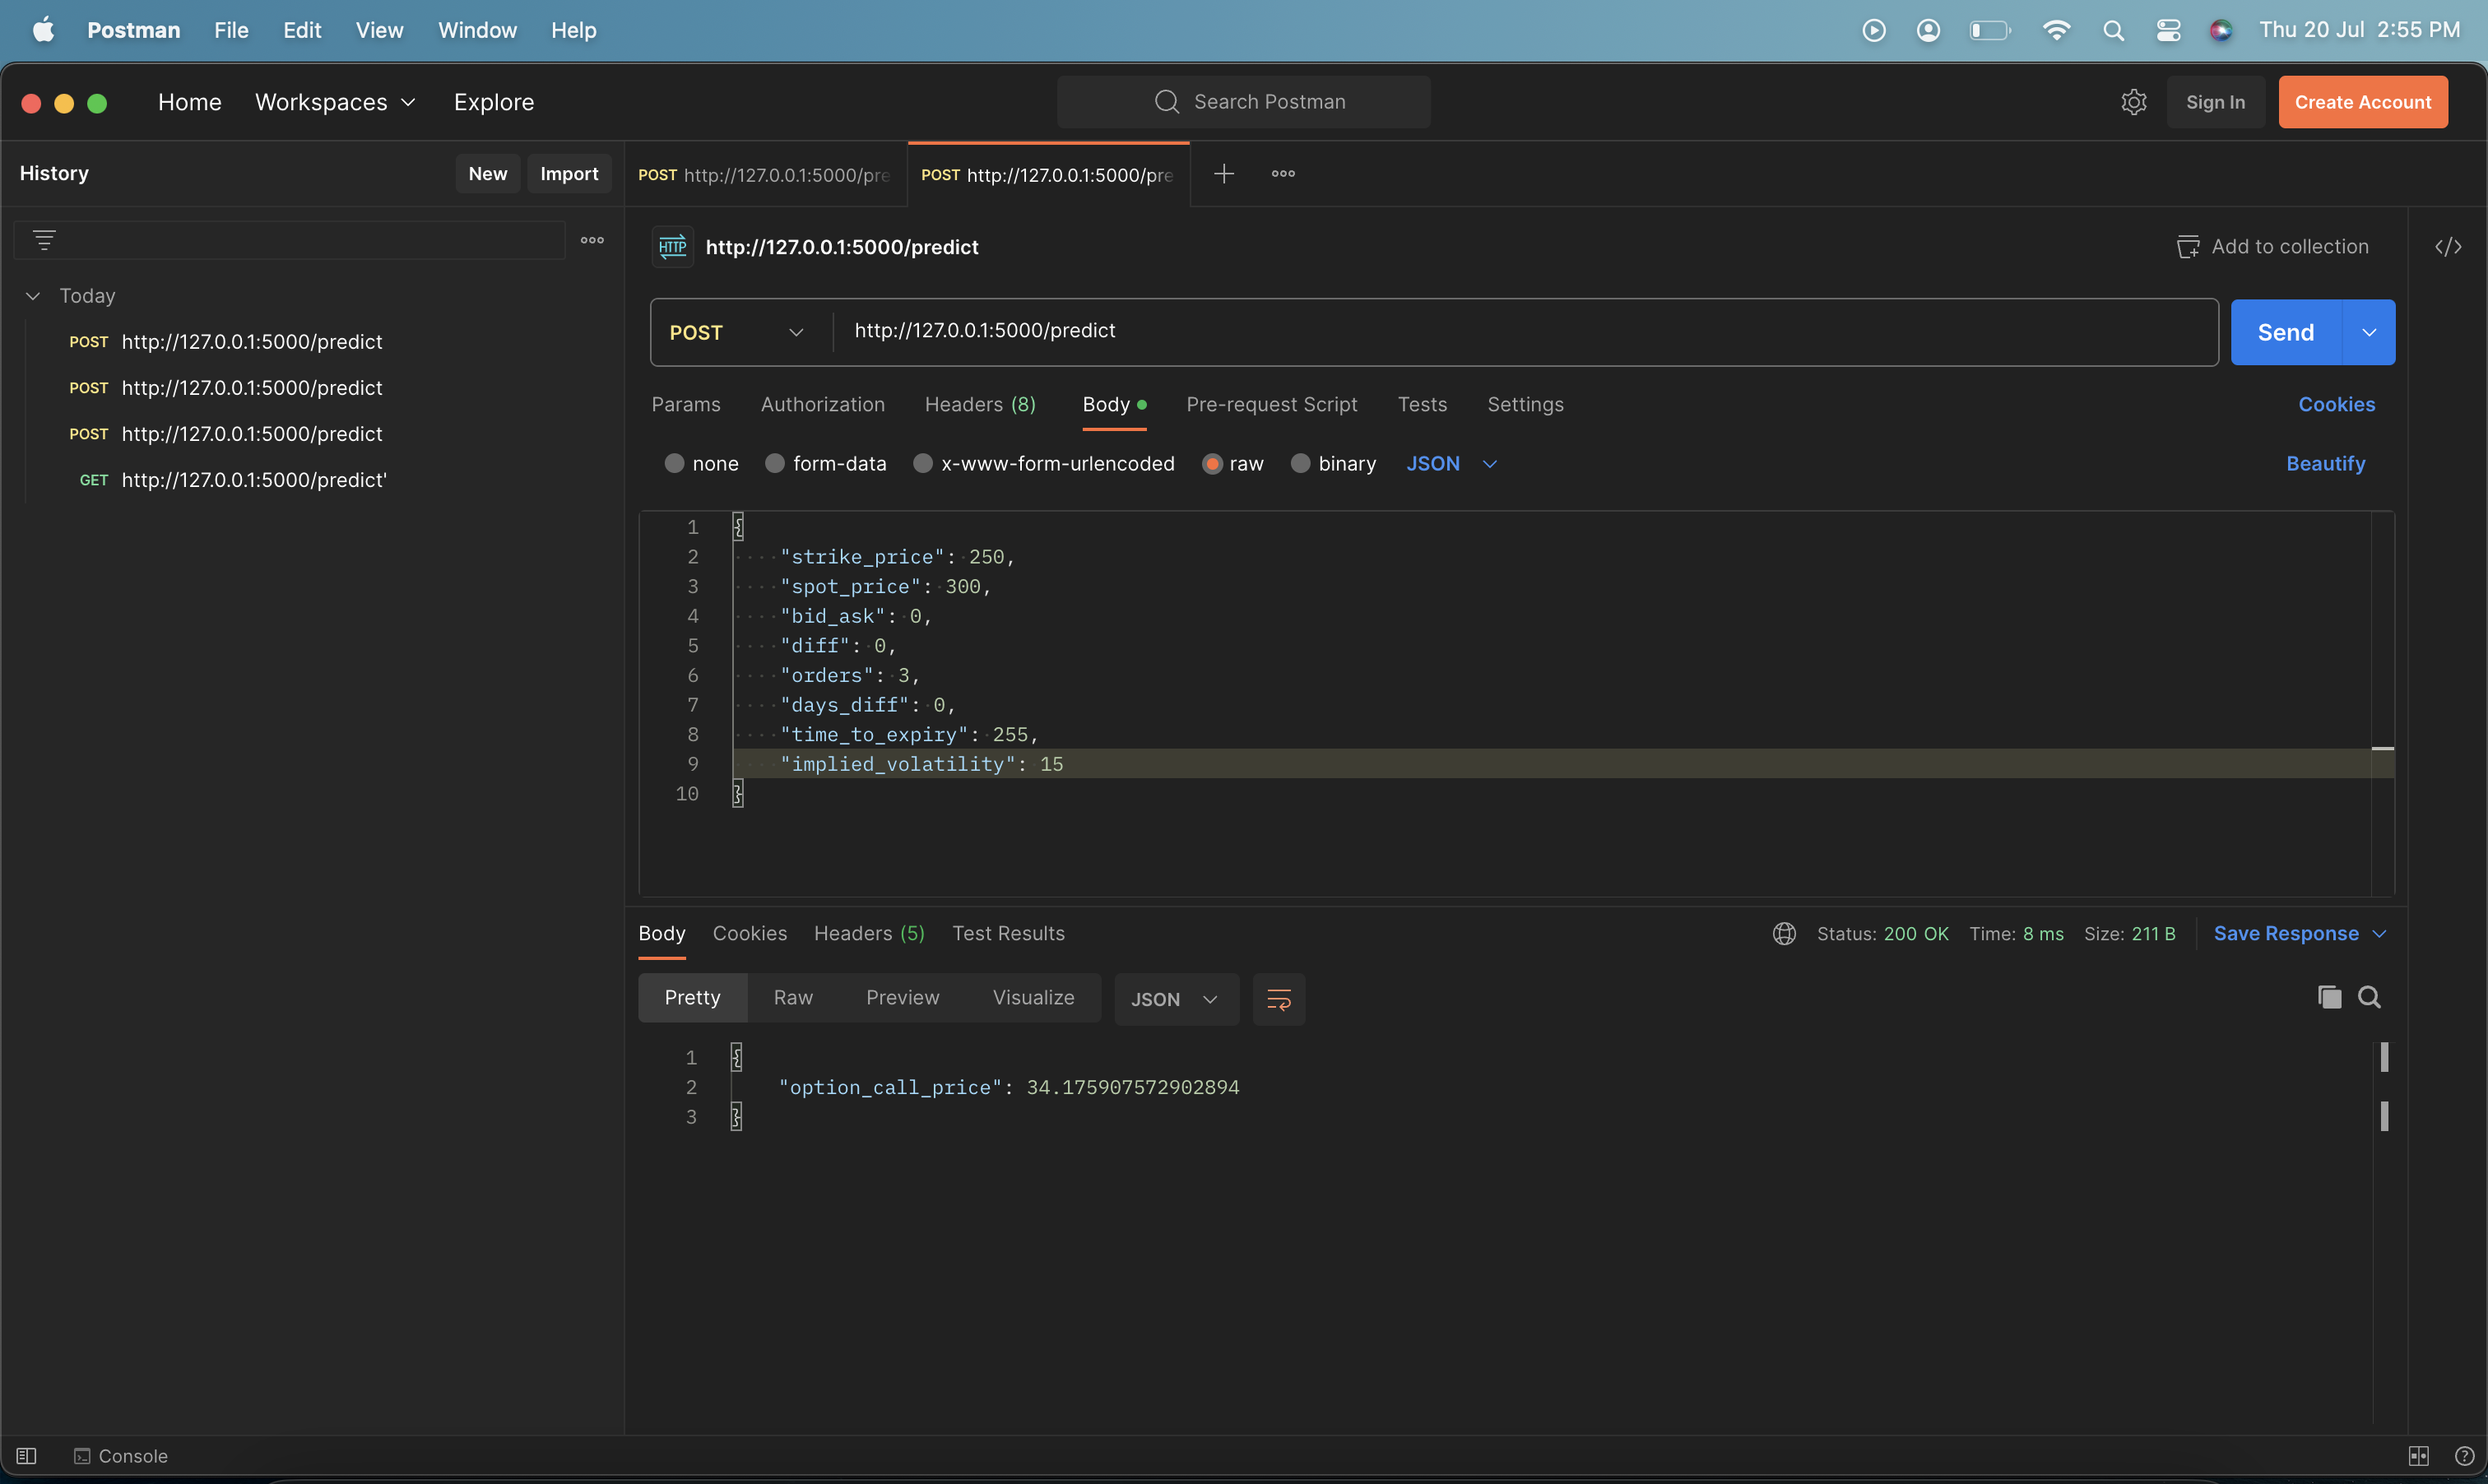

# Monte carlo simulation

import numpy as np

# Assuming the required inputs are available in your dataframe
expiry = df['Expiry']
strike_price = df['Strike_price']
spot_price = df['Spot_price']
risk_free_rate = 0.05  # Example risk-free rate
volatility = 0.2  # Example volatility

# Define the number of simulations and time steps
num_simulations = 1000
num_time_steps = 252  # Assuming daily time steps for one year

# Perform Monte Carlo simulation
option_prices = []
for _ in range(num_simulations):
    # Initialize the price trajectory with the spot price
    price_trajectory = [spot_price]

    for _ in range(num_time_steps):
        # Generate a random price change (log returns) from a normal distribution
        rand = np.random.normal(0, 1)
        price_change = risk_free_rate * expiry + volatility * np.sqrt(expiry) * rand

        # Calculate the next price based on the current price and price change
        next_price = price_trajectory[-1] * np.exp(price_change)
        price_trajectory.append(next_price)

    # Calculate the option call price at expiry using the last price in the trajectory
    call_price = np.maximum(price_trajectory[-1] - strike_price, 0)
    option_prices.append(call_price)

# Calculate the average option call price over all simulations
average_option_price = np.mean(option_prices)


X, y = df_call.iloc[:, :-1], df_call.iloc[:, -1]

print(X.shape)
print(y.shape)

X.head()

y.head()

from sklearn.model_selection import train_test_split
from sklearn import model_selection

# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=0)

X_train.head()

y_train.head()

print(y.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])

print(y_train.shape[0])
print(y_train[y_train==0].shape)
print(y_train[y_train==1].shape)

print(y_test.shape[0])
print(y_test[y_test==0].shape)
print(y_test[y_test==1].shape)

pip install xgboost

import xgboost as xgb
from sklearn import metrics

xgclf = xgb.XGBRegressor()

xgclf.fit(X_train, y_train)

df_call_train = df_call.iloc[:3550,:]
df_call_test = df_call.iloc[3550:,:]

df_call_train.shape

df_call_test.shape

df_call_train.head()

#### Visualizing the raw and the transformed data

# Plot
ls=['Strike_price','Spot_price','BidAsk', 'Diff(%)','Days_diff','Time_to_Expiry','Implied_Volatility','Option_call_price']
df=df_call_train[ls]
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(12,15))
for i, ax in enumerate(axes.flatten()):
        ax.plot(df[df.columns[i]], color='black', linewidth=1)
        ax.xaxis.set_major_locator(plt.MaxNLocator(3))
        # Decorations
        ax.set_title(df.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=12)

plt.tight_layout();

### Stationarity Test - ADF Test

for i in range(len(ls)):
    print('\n\n' + ls[i] + ': ADF test results:')
    result = adfuller(df_call_train[ls[i]].dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        if key=='5%':
            print('\t%s: %.3f' % (key, value))

## VAR MODEL

exog = df_call_train['BidAsk']
mod = sm.tsa.VARMAX(df_call_train[['Implied_Volatility', 'Option_call_price']], order=(1,0), trend='n')
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())
#Note the AIC value - lower AIC => better model

start_index = test.index.min()
end_index = test.index.max()
predictions = mod.fit().predict(start=start_index, end=end_index)

for i in range(predictions.shape[0]):
    if i==0:
        predictions.loc[predictions.index=='1979-01-01','lag_ln_inv']=train.iloc[74,4]
        predictions.loc[predictions.index=='1979-01-01','lag_ln_inc']=train.iloc[74,6]
    else:
        predictions.iloc[i,2]=predictions.iloc[i-1,4]
        predictions.iloc[i,3]=predictions.iloc[i-1,5]

    predictions['ln_inv']=(predictions['lag_ln_inv']+predictions['dln_inv'])
    predictions['ln_inc']=(predictions['lag_ln_inc']+predictions['dln_inc'])


    predictions['inv']=np.exp(predictions['ln_inv'])
    predictions['inc']=np.exp(predictions['ln_inc'])